In [60]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def get_data(art):
    r = requests.get(
        f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id={art}&retmode=json"
    ).json()["result"]
    keys = [i for i in r.keys() if i != "uids"][0]
    return r[keys]["sortpubdate"]


get_data("20550520")

'2010/08/01 00:00'

In [18]:
df=pd.read_csv('drugage.csv')

In [21]:
pubmeds=df.pubmed_id.unique()
ids={}
for i in pubmeds:
    try:
        ids[i]=get_data(i)
    except:
        print(f"Failed for {i}")

In [31]:
publication_dates=pd.Series(ids).to_frame().reset_index().rename(
    columns={"index": "pubmed_id", 0: "publication_date"}
).assign(publication_date=lambda x: pd.to_datetime(x.publication_date))

In [41]:
df2=pd.merge(df, publication_dates, how="left").query('significance not in ["NS","N"]')[
    ["species", "avg_lifespan_change",'max_lifespan_change','gender','publication_date','compound_name']
]

In [57]:
specs=df2.species.value_counts().index
specs

Index(['Caenorhabditis elegans', 'Drosophila melanogaster', 'Mus musculus',
       'Saccharomyces cerevisiae', 'Zaprionus paravittiger',
       'Rattus norvegicus', 'Drosophila virilis', 'Asplanchna brightwelli',
       'Drosophila kikkawai', 'Acheta domesticus', 'Drosophila bipectinata',
       'Brachionus manjavacas', 'Nothobranchius guentheri', 'Aeolosoma viride',
       'Paramecium tetraurelia', 'Mytilina brevispina', 'Anastrepha ludens',
       'Philodina acuticornis', 'Nothobranchius furzeri', 'Bombyx mori',
       'Musca domestica', 'Musca Domestica', 'Aedes aegypti',
       'Ceriodaphnia affinis', 'Podospora anserina', 'Philodina',
       'Mesocricetus auratus', 'Tribolium castaneum', 'Apis mellifera',
       'Canis lupus familiaris', 'Daphnia pulex clone TCO'],
      dtype='object')

In [73]:
df2

,species,avg_lifespan_change,max_lifespan_change,gender,publication_date,compound_name
6,Drosophila melanogaster,30.00,NaN,NaN,2009-11-01,Spermidine
7,Saccharomyces cerevisiae,233.00,NaN,NaN,2009-11-01,Spermidine
8,Caenorhabditis elegans,15.00,NaN,NaN,2009-11-01,Spermidine
9,Mus musculus,23.79,NaN,Male,2017-06-01,Spermidine
10,Mus musculus,11.30,NaN,Female,2016-12-01,Spermidine
11,Mus musculus,6.50,NaN,NaN,2016-12-01,Spermidine
12,Mus musculus,8.00,0.00,Male,2008-10-01,Aspirin
13,Caenorhabditis elegans,23.00,NaN,NaN,2013-02-10,Aspirin
14,Caenorhabditis elegans,20.90,NaN,NaN,2013-02-10,Aspirin
15,Caenorhabditis elegans,16.00,NaN,NaN,2013-05-01,Aspirin


In [79]:
df2.query("species==@specs[0]").sort_values('max_lifespan_change').dropna(subset=['max_lifespan_change'])

,species,avg_lifespan_change,max_lifespan_change,gender,publication_date,compound_name
296,Caenorhabditis elegans,-23.75,-20.97,NaN,2016-01-01,Glucose
289,Caenorhabditis elegans,-23.60,-17.24,NaN,2016-01-01,Glucose
986,Caenorhabditis elegans,-16.00,-15.00,NaN,2011-01-01,Plumbagin
791,Caenorhabditis elegans,-16.60,-13.14,NaN,2018-04-01,Epigallocatechin-3-gallate
988,Caenorhabditis elegans,-11.00,-13.00,NaN,2011-01-01,Plumbagin
790,Caenorhabditis elegans,-7.90,-10.85,NaN,2018-04-01,Epigallocatechin-3-gallate
292,Caenorhabditis elegans,-17.65,-8.33,NaN,2016-01-01,Glucose
1653,Caenorhabditis elegans,-6.68,-6.40,NaN,2017-04-01,Diethyl Maleate
1651,Caenorhabditis elegans,-8.72,-6.36,NaN,2017-04-01,Menadione
1498,Caenorhabditis elegans,15.13,-4.34,NaN,2017-10-01,α‐linolenic acid


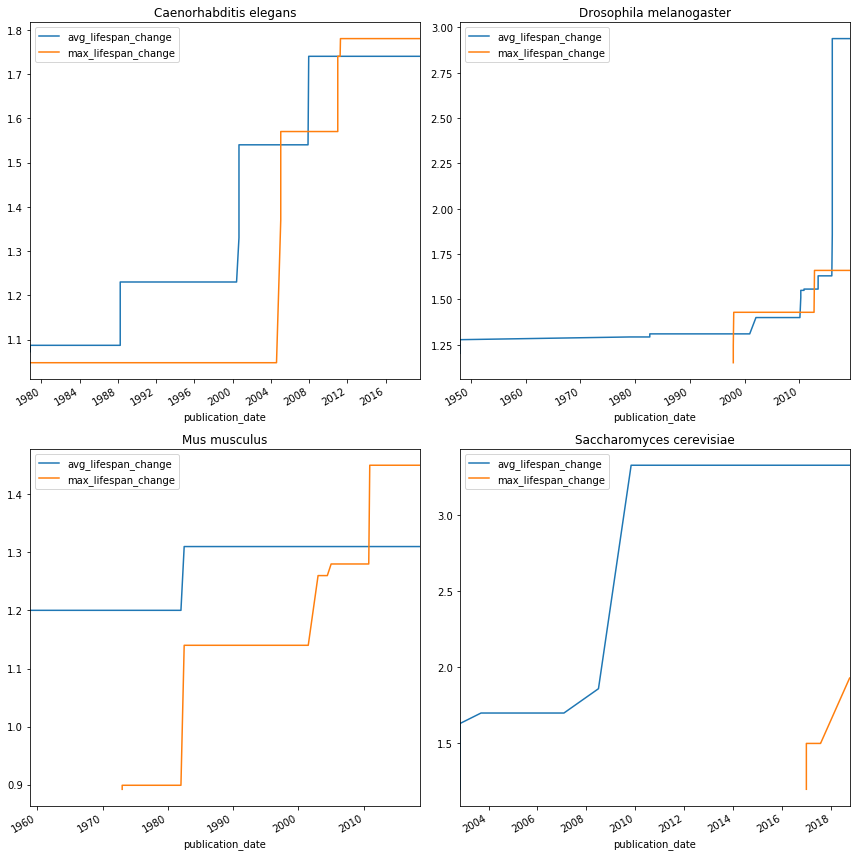

In [74]:
def plot_species(species):
    df2.query('species==@species').sort_values(
        "publication_date"
    ).set_index("publication_date")[
        ["avg_lifespan_change", "max_lifespan_change"]
    ].expanding().max().pipe(lambda x: (x+100)/100).plot(ax=plt.gca())
    plt.title(f'{species}')
    plt.ylabel('')
plt.figure(figsize=(12,12))
for p,specie in enumerate(specs[:4]):
    plt.subplot(2,2,p+1)
    plot_species(specie)
plt.tight_layout()
plt.savefig("fig.png")